In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
import torch.optim as optim

rno = 102316085

In [5]:
df = pd.read_csv( "/kaggle/input/indian-air-quality/data.csv",encoding='latin1')
print(df.head())
print(df.columns)


/tmp/ipykernel_55/783902399.py:1: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv( "/kaggle/input/indian-air-quality/data.csv",encoding='latin1')


  stn_code       sampling_date           state   location agency  \
0    150.0  February - M021990  Andhra Pradesh  Hyderabad    NaN   
1    151.0  February - M021990  Andhra Pradesh  Hyderabad    NaN   
2    152.0  February - M021990  Andhra Pradesh  Hyderabad    NaN   
3    150.0     March - M031990  Andhra Pradesh  Hyderabad    NaN   
4    151.0     March - M031990  Andhra Pradesh  Hyderabad    NaN   

                                 type  so2   no2  rspm  spm  \
0  Residential, Rural and other Areas  4.8  17.4   NaN  NaN   
1                     Industrial Area  3.1   7.0   NaN  NaN   
2  Residential, Rural and other Areas  6.2  28.5   NaN  NaN   
3  Residential, Rural and other Areas  6.3  14.7   NaN  NaN   
4                     Industrial Area  4.7   7.5   NaN  NaN   

  location_monitoring_station  pm2_5        date  
0                         NaN    NaN  1990-02-01  
1                         NaN    NaN  1990-02-01  
2                         NaN    NaN  1990-02-01  
3       

In [6]:
X=df['no2'].dropna().values
X[:5]

array([17.4,  7. , 28.5, 14.7,  7.5])

In [7]:
X.dtype
X.astype(np.float32)

array([17.4,  7. , 28.5, ..., 45. , 50. , 46. ], dtype=float32)

In [9]:
ar = 0.5*(rno%7)
br = 0.3*((rno%5) + 1)

print(ar)
print(br)

2.0
0.3


In [33]:
z = X + ar*np.sin(br*X)
Z_tensor=torch.tensor(z,dtype=torch.float32).view(-1,1)

Z_tensor

tensor([[15.6522],
        [ 8.7264],
        [30.0348],
        ...,
        [46.6076],
        [51.3006],
        [47.8874]])

In [44]:
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.net=nn.Sequential(
            nn.Linear(1,16),
            nn.ReLU(),
            nn.Linear(16,16),
            nn.ReLU(),
            nn.Linear(16,1),
        )

    def forward(self,x):
        return self.net(x)


class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(1, 16),
            nn.ReLU(),
            nn.Linear(16, 16),
            nn.ReLU(),
            nn.Linear(16, 1),
            nn.Sigmoid(),
        )

    def forward(self,x):
        return self.net(x)

In [45]:
g=Generator()
d=Discriminator()
critera=nn.BCELoss()

g_optimizer=optim.Adam(g.parameters(),lr=0.001)
d_optimizer=optim.Adam(d.parameters(),lr=0.001)

epochs=3000
batch_size=64

In [46]:
for epoch in range(epochs):
    idx=np.random.randint(0,len(Z_tensor),batch_size)
    real_samples=Z_tensor[idx]

    real_labels=torch.ones(batch_size,1)
    fake_labels=torch.zeros(batch_size,1)

    noise=torch.randn(batch_size,1)
    fake_samples=g(noise)

    d_real=d(real_samples)
    d_fake=d(fake_samples.detach())

    d_loss=critera(d_real,real_labels) + critera(d_fake,fake_labels)

    d_optimizer.zero_grad()
    d_loss.backward()
    d_optimizer.step()

    noise=torch.randn(batch_size,1)
    fake_samples=g(noise)
    d_fake=d(fake_samples)

    g_loss=critera(d_fake,real_labels)

    g_optimizer.zero_grad()
    g_loss.backward()
    g_optimizer.step()

    if epoch%500==0:
        print(f'epoch {epoch} and D loss: {d_loss.item():.2f} and G loss: {g_loss.item():.2f}')

epoch 0 and D loss: 1.38 and G loss: 0.73
epoch 500 and D loss: 1.46 and G loss: 0.90
epoch 1000 and D loss: 1.39 and G loss: 0.65
epoch 1500 and D loss: 1.36 and G loss: 0.76
epoch 2000 and D loss: 1.32 and G loss: 0.83
epoch 2500 and D loss: 1.39 and G loss: 0.74


In [50]:
noise=torch.randn(10000,1)
z_fake=g(noise).detach().numpy().flatten()

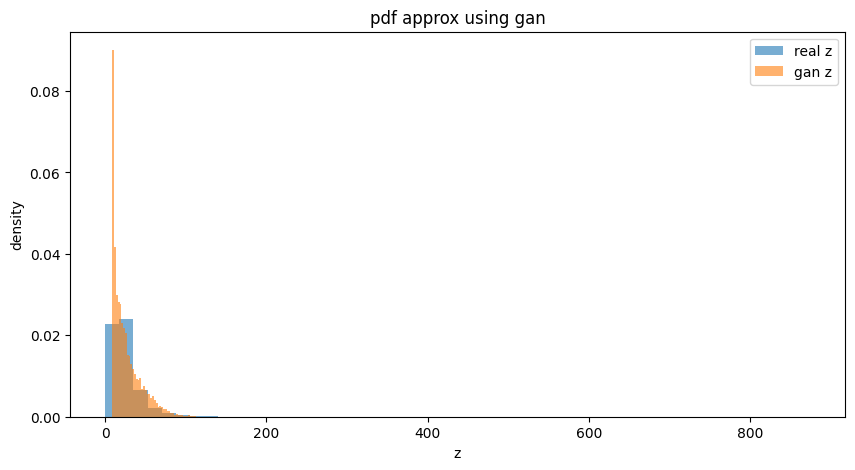

In [51]:
plt.figure(figsize=(10,5))
plt.hist(z,bins=50, density=True, alpha=0.6, label="real z")
plt.hist(z_fake,bins=50, density=True, alpha=0.6, label="gan z")

plt.xlabel('z')
plt.ylabel('density')
plt.title('pdf approx using gan')
plt.legend()
plt.show()